In [1]:
import os
import libcovid19 as covid

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
# to use altair for plots
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return alt.pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir', data_dir='mydata')

DataTransformerRegistry.enable('json_dir')

In [4]:
# source of the data: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
#path = 'COVID-19-geographic-disbtribution-worldwide-2020-03-21.xlsx'

In [5]:
# read the data
#df = pd.read_excel(path, dtype=str)
df = covid.get_latest_data()

# pre-process the dataframe
df = covid.process_data_for_plot(df, min_deaths_number=80, n_death_date_origin=10)

In [6]:
list_countries = df['country'].unique().tolist()
print(list_countries)
print(len(list_countries))
#
display(df.head(10))

['Belgium', 'China', 'France', 'Germany', 'Iran', 'Italy', 'Netherlands', 'South_Korea', 'Spain', 'United_Kingdom', 'United_States_of_America']
11


,cases,deaths,country,date,cumul_deaths,cumul_cases,date_10_deaths,days_since_10_death
80,309,7,Belgium,2020-03-20,21,1795,2020-03-19,1
81,462,16,Belgium,2020-03-21,37,2257,2020-03-19,2
82,558,30,Belgium,2020-03-22,67,2815,2020-03-19,3
83,586,8,Belgium,2020-03-23,75,3401,2020-03-19,4
84,342,13,Belgium,2020-03-24,88,3743,2020-03-19,5
108,97,0,China,2020-01-23,17,623,2020-01-22,1
109,259,9,China,2020-01-24,26,882,2020-01-22,2
110,441,15,China,2020-01-25,41,1323,2020-01-22,3
111,665,15,China,2020-01-26,56,1988,2020-01-22,4
112,787,25,China,2020-01-27,81,2775,2020-01-22,5


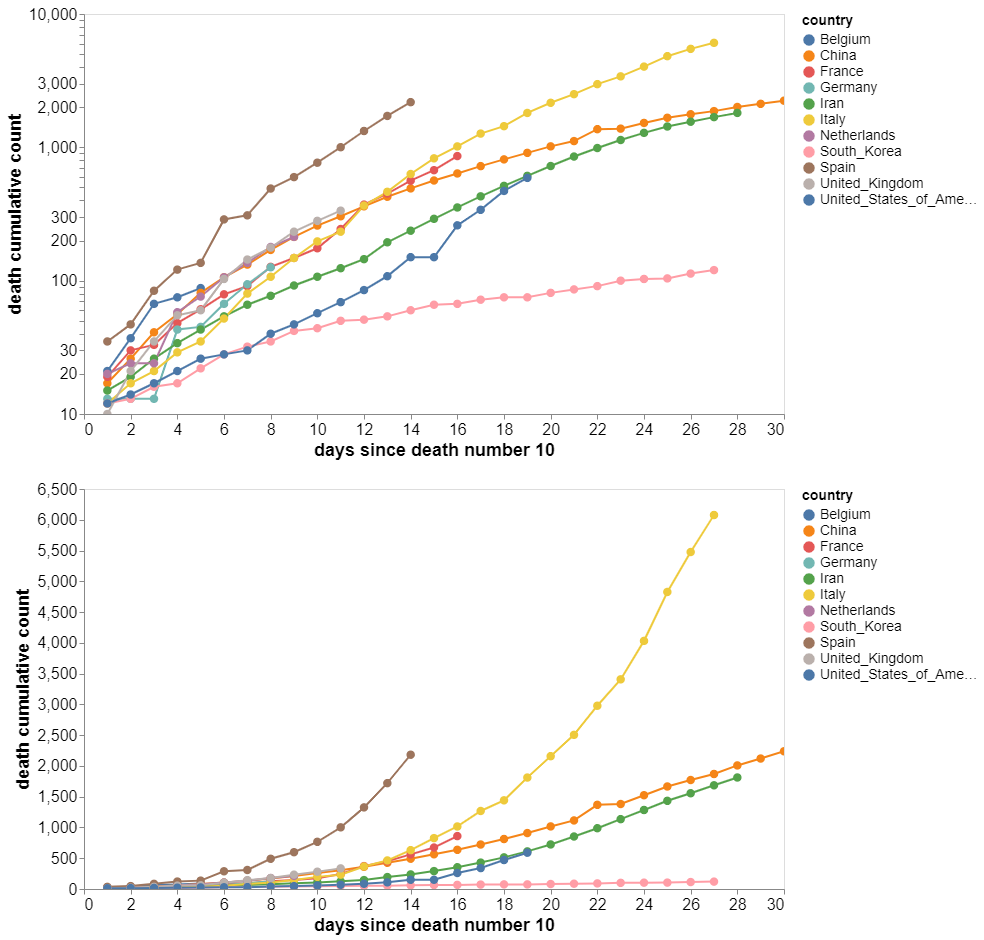

In [7]:
chart = covid.get_altair_chart(df)

# save the plot as a html file
path_output_plot = os.path.join('plots','charts_covid_19.html')
chart.save(path_output_plot)

# print the chart
display(chart)